# Análiose de vendas 

#### Imports e base de dados

In [364]:
import duckdb # pra usar o SQL
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [365]:
# Dados dos clientes e localização básica
clientes = duckdb.query('select * from "dados/olist_customers_dataset.csv"').df()

# Itens de cada pedido, produtos e preços
item_pedido = duckdb.query('select * from "dados/olist_order_items_dataset.csv"').df()

# Dados gerais dos pedidos, status e datas
pedidos = duckdb.query('select * from "dados/olist_orders_dataset.csv"').df()

# Informações de pagamentos por pedido
pagamentos = duckdb.query('select * from "dados/olist_order_payments_dataset.csv"').df()

# Detalhes dos produtos, categorias e dimensões
info_produto = duckdb.query('select * from "dados/olist_products_dataset.csv"').df()

# Avaliações e comentários dos pedidos
review = duckdb.query('select * from "dados/olist_order_reviews_dataset.csv"').df()
# criei variaveis para pegar as tabelas usando SQL

In [366]:
# Criando Data Frame com base nos campos desejados
df = duckdb.query('''
select 
  i.product_category_name as categoria,
  p.order_purchase_timestamp as data_pedido,
  p.order_status as status_pedido,
  ip.price as valor_produto,
  fp.payment_type as forma_pagamento,
  rv.review_score as nota,
  ec.customer_state as estado
  
from pedidos p
  left join item_pedido ip on p.order_id = ip.order_id
  left join info_produto i on ip.product_id = i.product_id
  left join pagamentos fp on p.order_id = fp.order_id
  left join review rv on p.order_id = rv.order_id
  left join clientes ec on p.customer_id = ec.customer_id
  
''').df()

## Tratando dados

In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   categoria        116601 non-null  object        
 1   data_pedido      119143 non-null  datetime64[us]
 2   status_pedido    119143 non-null  object        
 3   valor_produto    118310 non-null  float64       
 4   forma_pagamento  119140 non-null  object        
 5   nota             118146 non-null  Int64         
 6   estado           119143 non-null  object        
dtypes: Int64(1), datetime64[us](1), float64(1), object(4)
memory usage: 6.5+ MB


In [369]:
# ajustando a data
df['data_pedido'] = df['data_pedido'].dt.strftime('%d/%m/%y')

# ajustando a data      
df['data_pedido'] = pd.to_datetime(df['data_pedido'], format= '%d/%m/%y')

df.sample(2)

,categoria,data_pedido,status_pedido,valor_produto,forma_pagamento,nota,estado
7861,esporte_lazer,2018-05-24,delivered,74.9,credit_card,5,SP
64600,cool_stuff,2018-03-19,delivered,239.0,credit_card,5,PR


In [370]:
# removendo dados nulos no campo de categorias
df = df.dropna(subset = (['categoria']))
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116601 entries, 0 to 119142
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   categoria        116601 non-null  object        
 1   data_pedido      116601 non-null  datetime64[ns]
 2   status_pedido    116601 non-null  object        
 3   valor_produto    116601 non-null  float64       
 4   forma_pagamento  116598 non-null  object        
 5   nota             115637 non-null  Int64         
 6   estado           116601 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), object(4)
memory usage: 7.2+ MB


In [371]:
# removendo dados duplicados
df = df.drop_duplicates().reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101110 entries, 0 to 101109
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   categoria        101110 non-null  object        
 1   data_pedido      101110 non-null  datetime64[ns]
 2   status_pedido    101110 non-null  object        
 3   valor_produto    101110 non-null  float64       
 4   forma_pagamento  101109 non-null  object        
 5   nota             100326 non-null  Int64         
 6   estado           101110 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), object(4)
memory usage: 5.5+ MB


In [372]:
# estatisticas descritivas da base 
df.describe().round(2)

,data_pedido,valor_produto,nota
count,101110,101110.00,100326.0
mean,2017-12-31 11:30:51.662545664,125.35,4.08
min,2016-09-04 00:00:00,0.85,1.0
25%,2017-09-12 00:00:00,41.00,4.0
50%,2018-01-19 00:00:00,79.00,5.0
75%,2018-05-05 00:00:00,139.90,5.0
max,2018-09-03 00:00:00,6735.00,5.0
std,NaN,189.71,1.35


A base aparenta ter posiveis outliers, o terceiro quartio Q3 esta bem distante do valor maximo, 

e a media esta inferior ao Q3 indicando que a maioria dos dados estão a baixo do Q3, 

desvio padrão (STD) é maior que a media, reforçando que existem valores extremos

<Axes: xlabel='valor_produto'>

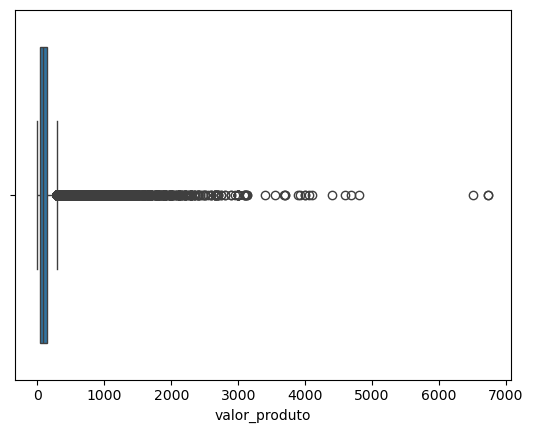

In [374]:
# visualizando outliers
sns.boxplot(data = df, x = 'valor_produto')

In [375]:
# Removendo outliers 
# separando Quatis
Q1 = df['valor_produto'].quantile(.25)
Q3 = df['valor_produto'].quantile(.75)
IQR = Q3 - Q1

# Definindo limites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# aplicando o filtro
df = df[  (df['valor_produto']  >= limite_inferior ) & (df['valor_produto'] <= limite_superior)  ].reset_index(drop=True)

In [376]:
# Revendo dados estatisticos da base
df[['valor_produto']].describe().round(2)

,valor_produto
count,93378.00
mean,86.78
std,60.39
min,0.85
25%,39.90
50%,69.90
75%,119.90
max,288.02


Após a remoção dos outliers, a base apresenta valores mais consistentes. A média (86.79) aproximou-se dos quartis, 
refletindo melhor representatividade dos dados. O desvio padrão reduziu de 189.71 para 60.39, 
indicando menor dispersão e maior homogeneidade. O valor máximo caiu de 6735.00 para 288.02, 
eliminando distorções que influenciavam a análise. Assim, o conjunto está mais equilibrado e confiável para estudos estatísticos.

## questões de negocio

**Quais categorias de produto geram maior receita?**

* Analisar faturamento total por categoria e identificar as mais lucrativas.

In [380]:
# criando registro do Data Frame no duckdb
duckdb.register('df',df)

# Criando agrupamento entre categoria e valor do produto 
receita_categoria = duckdb.query('''
SELECT 
    categoria,
    sum(valor_produto) as receita
FROM df
GROUP BY categoria
ORDER BY receita DESC
''').df()
receita_categoria.head(2)

,categoria,receita
0,cama_mesa_banho,876955.28
1,esporte_lazer,683451.44


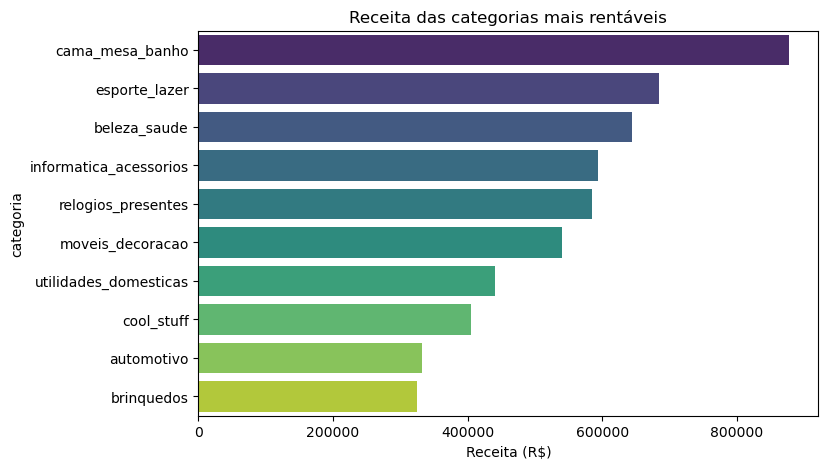

In [381]:
# visualização da receita das categorias mais rentáveis
filtro_top_10 = receita_categoria[:10]
plt.figure(figsize=(8,5))
sns.barplot(data=filtro_top_10,
            x='receita', 
            y='categoria', 
            hue='categoria',
            palette='viridis')
plt.title('Receita das categorias mais rentáveis')
plt.xlabel("Receita (R$)")
plt.show()

**Qual estado tem mais vendas dessas categorias**

In [383]:
# receita_categoria pegar o top 10

In [384]:
# criando lista com as categorias desejadas
lista_categorias = receita_categoria['categoria'][:10].to_list()

# filtrando as categorias
filtro_categoria = df[df['categoria'].isin(lista_categorias)]

# Criando agrupamento entre estado e vendas
melhores_estados = filtro_categoria.groupby('estado').agg(
    total_vendas = pd.NamedAgg('valor_produto','sum')
).sort_values(by='total_vendas', ascending=False)

In [385]:
melhores_estados[:3]

,total_vendas
estado,
SP,2197674.92
RJ,727880.82
MG,645416.30


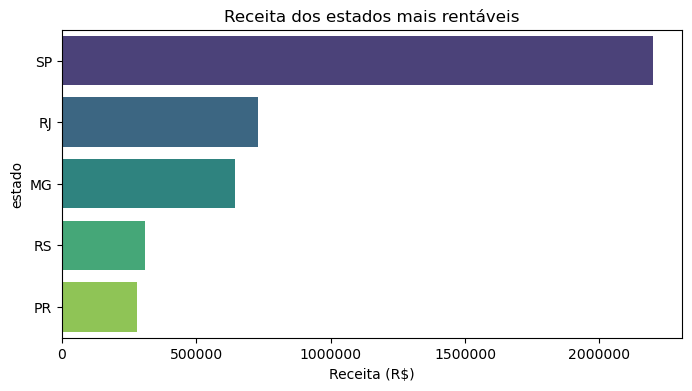

In [386]:
# visualização da receita das categorias mais rentáveis
filtro_top_5 = melhores_estados[:5]
plt.figure(figsize=(8,4))
ax = sns.barplot(data=filtro_top_5,
            x='total_vendas', 
            y='estado', 
            hue='estado',
            palette='viridis')
plt.title('Receita dos estados mais rentáveis')
plt.xlabel("Receita (R$)")
ax.ticklabel_format(style='plain', axis='x')
plt.show()

**Conclusão: A análise mostra que São Paulo (SP) lidera em vendas, com R$ 2.197.629,93, seguido por RJ e MG, demonstrando um desempenho sólido na região Sudeste.**

**Os demais estados também contribuem de forma relevante para a receita total, 
evidenciando um mercado distribuído, embora em volumes menores que SP**